In [213]:
import numpy 
import matplotlib.pyplot as plt
import pandas as pd

In [214]:
# Path setting
directory = './data/Waveform/'
filename = '20250909_waveform3'
extension = '.csv'

# Load data
full_path = directory + filename + extension
data = pd.read_csv(full_path)

In [215]:
import pandas as pd
import numpy as np

# Work directly on the Series (no .to_numpy yet)
time = pd.to_numeric(data['Time'], errors='coerce').to_numpy()
MI_signal = pd.to_numeric(data['Channel B'], errors='coerce').to_numpy()
Trigger   = pd.to_numeric(data['Channel C'], errors='coerce').to_numpy()

# Drop NaN values from the time array (caused by '(ms)')
mask = ~np.isnan(time)
time = time[mask]
MI_signal = MI_signal[mask]
Trigger = Trigger[mask]

# Post process
offset = 0.5*(np.max(MI_signal) + np.min(MI_signal))
MI_signal_norm = (MI_signal - offset)/np.max(MI_signal - offset)


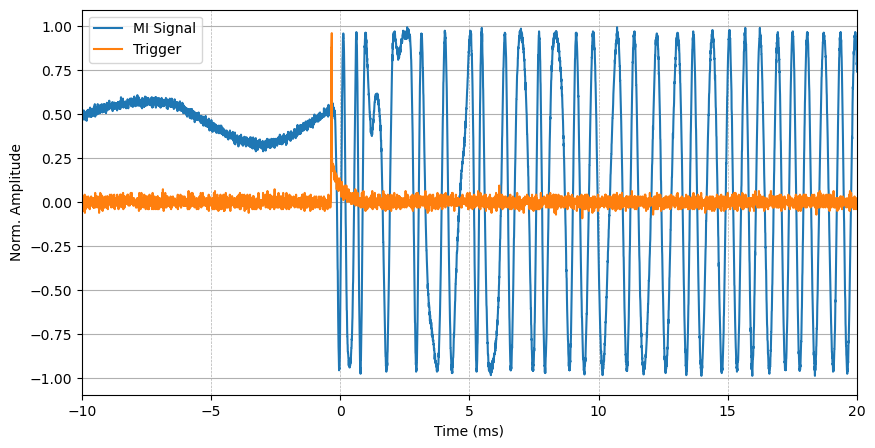

In [216]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time[::5], MI_signal_norm[::5], label='MI Signal')   # every 2nd point
plt.plot(time[::5], Trigger[::5]/np.max(Trigger), label='Trigger')       # every 2nd point
plt.xlabel('Time (ms)')
plt.ylabel('Norm. Amplitude')
plt.xlim(-10, 20)
# plt.ylim(-1.5, 1.5)
plt.grid(True)
# Add grid lines every 5 seconds
# plt.xticks(np.arange(-10, max(time), 5))
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()


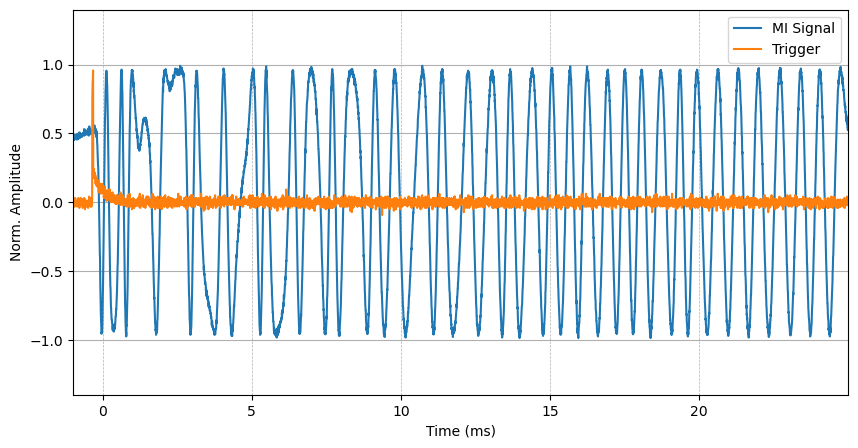

In [220]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time[::5], MI_signal_norm[::5], label='MI Signal')   # every 2nd point
plt.plot(time[::5], Trigger[::5]/np.max(Trigger), label='Trigger')       # every 2nd point
plt.xlabel('Time (ms)')
plt.ylabel('Norm. Amplitude')
plt.xlim(-1, 25)
plt.ylim(-1.4, 1.4)
plt.grid(True)
# Add grid lines every 5 seconds
plt.xticks(np.arange(0, 25, 5))
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

=== Sine fit on ROI ===
ROI: [15.000, 20.000] ms, N=4961
A=0.918631, b=10.2747 rad/ms (f=1635.27 Hz), c=0.983111 rad, d=0.0120087
RMSE=0.189707


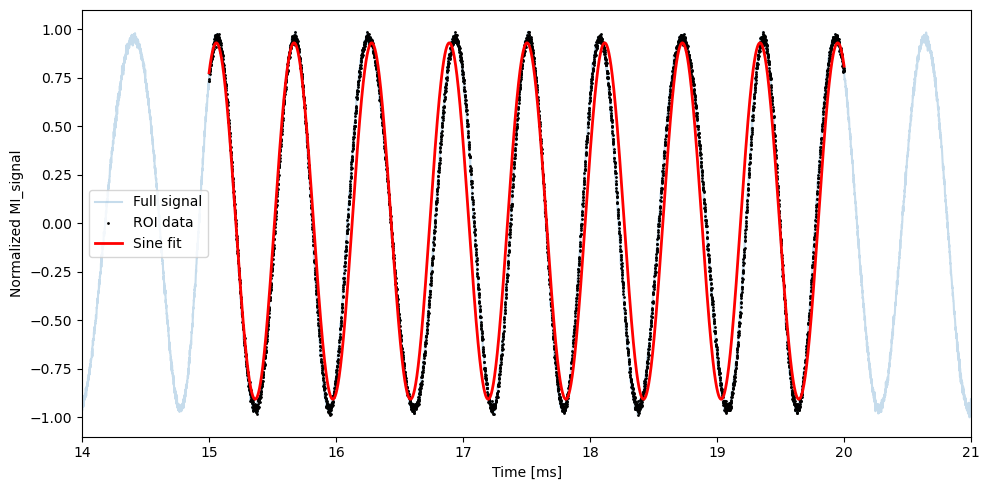

In [ ]:
from scipy.optimize import curve_fit

# ====== SETTINGS ======
t_start_ms = 15
t_end_ms   = 20
# ======================

# --- ROI ---
idx = (time >= t_start_ms) & (time <= t_end_ms)
x = np.asarray(time[idx], float)              # ms
y = np.asarray(MI_signal_norm[idx], float)

# shift x origin for conditioning
x0 = float(x.min())
x = x - x0

# ===== Initial guess via FFT (for b) =====
t_s = x * 1e-3
dt = np.median(np.diff(t_s)) if len(t_s) > 1 else np.nan
if np.isfinite(dt) and dt > 0:
    Y = np.fft.rfft(y - y.mean())
    freqs = np.fft.rfftfreq(len(y), d=dt)
    f0 = freqs[1 + np.argmax(np.abs(Y[1:]))] if len(freqs) > 1 else 1.0
else:
    f0 = 1.0
b0 = 2*np.pi*f0/1000.0  # rad/ms

# Simple initials
A0 = max(1e-6, 0.5*np.ptp(y))
c0 = 0.0
d0 = 0.0
p0 = [A0, max(b0, 1e-6), c0, d0]

# Bounds (tight d in [-0.1, 0.1])
A_max = 1.1
b_lo  = max(1e-6, 0.25*b0)
b_hi  = max(1e-3, 4.0*b0)
bounds = ([0.9, b_lo, 0, -0.1],
          [A_max, b_hi,  2*np.pi,  0.1])

# Fit
def sine_model(t, A, b, c, d): return A*np.sin(b*t + c) + d
popt, pcov = curve_fit(sine_model, x, y, p0=p0, bounds=bounds, maxfev=30000)
A, b, c, d = popt
y_fit = sine_model(x, A, b, c, d)

# Report
rmse = float(np.sqrt(np.mean((y - y_fit)**2)))
f_hz = b * 1000.0 / (2*np.pi)
print("=== Sine fit on ROI ===")
print(f"ROI: [{t_start_ms:.3f}, {t_end_ms:.3f}] ms, N={len(x)}")
print(f"A={A:.6g}, b={b:.6g} rad/ms (f={f_hz:.6g} Hz), c={c:.6g} rad, d={d:.6g}")
print(f"RMSE={rmse:.6g}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(time, MI_signal_norm, alpha=0.25, label="Full signal")
plt.plot(x + x0, y, 'k.', ms=2, label="ROI data")
plt.plot(x + x0, y_fit, 'r-', lw=2, label="Sine fit")
plt.xlabel("Time [ms]"); plt.ylabel("Normalized MI_signal")
plt.xlim(t_start_ms-1, t_end_ms+1)
plt.legend(); plt.tight_layout(); plt.show()


=== Sine fit on ROI ===
ROI: [15.000, 20.000] ms, N=4961
A=0.918631, b=10.2747 rad/ms (f=1635.27 Hz), c=0.983111 rad, d=0.0120087
RMSE=0.189707,  mean(res)=1.37e-13,  std(res)=0.19


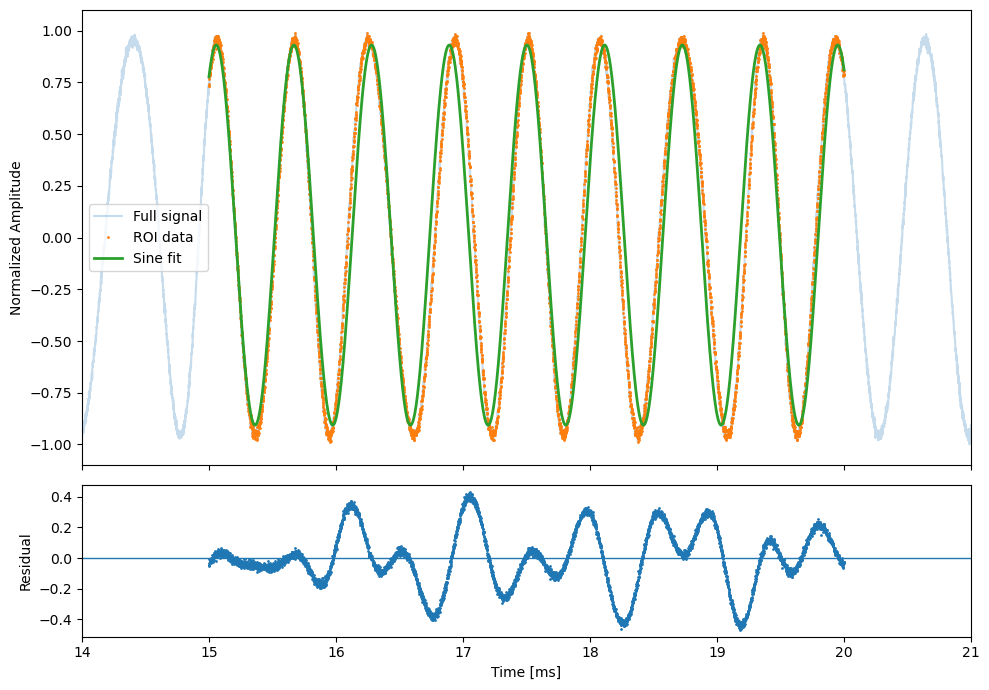

In [19]:
from scipy.optimize import curve_fit

# ====== SETTINGS ======
t_start_ms = 15
t_end_ms   = 20
# ======================

# --- ROI ---
idx = (time >= t_start_ms) & (time <= t_end_ms)
x = np.asarray(time[idx], float)              # ms
y = np.asarray(MI_signal_norm[idx], float)

# shift x origin for conditioning
x0 = float(x.min())
x = x - x0

# ===== Initial guess via FFT (for b) =====
t_s = x * 1e-3
dt = np.median(np.diff(t_s)) if len(t_s) > 1 else np.nan
if np.isfinite(dt) and dt > 0:
    Y = np.fft.rfft(y - y.mean())
    freqs = np.fft.rfftfreq(len(y), d=dt)
    f0 = freqs[1 + np.argmax(np.abs(Y[1:]))] if len(freqs) > 1 else 1.0
else:
    f0 = 1.0
b0 = 2*np.pi*f0/1000.0  # rad/ms

# Simple initials
A0 = max(1e-6, 0.5*np.ptp(y))
c0 = 0.0
d0 = 0.0
p0 = [A0, max(b0, 1e-6), c0, d0]

# Bounds (tight d in [-0.1, 0.1])
A_max = 1.1
b_lo  = max(1e-6, 0.25*b0)
b_hi  = max(1e-3, 4.0*b0)
bounds = ([0.9, b_lo, 0, -0.1],
          [A_max, b_hi,  2*np.pi,  0.1])

# Fit
def sine_model(t, A, b, c, d): return A*np.sin(b*t + c) + d
popt, pcov = curve_fit(sine_model, x, y, p0=p0, bounds=bounds, maxfev=30000)
A, b, c, d = popt
y_fit = sine_model(x, A, b, c, d)

# Residuals
res = y - y_fit
rmse = float(np.sqrt(np.mean(res**2)))
f_hz = b * 1000.0 / (2*np.pi)

print("=== Sine fit on ROI ===")
print(f"ROI: [{t_start_ms:.3f}, {t_end_ms:.3f}] ms, N={len(x)}")
print(f"A={A:.6g}, b={b:.6g} rad/ms (f={f_hz:.6g} Hz), c={c:.6g} rad, d={d:.6g}")
print(f"RMSE={rmse:.6g},  mean(res)={np.mean(res):.3g},  std(res)={np.std(res, ddof=1):.3g}")

# Plots: fit + residuals (shared x)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(time, MI_signal_norm, alpha=0.25, label="Full signal")
ax1.plot(x + x0, y, '.', ms=2, label="ROI data")
ax1.plot(x + x0, y_fit, '-', lw=2, label="Sine fit")
ax1.set_ylabel("Normalized Amplitude")
ax1.legend(loc='best')

ax2.plot(x + x0, res, '.', ms=2)
ax2.axhline(0, lw=1)
ax2.set_xlim(t_start_ms-1, t_end_ms+1)
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Residual")

plt.tight_layout()
plt.show()

# Optional: residual histogram (uncomment if wanted)
# plt.figure(figsize=(6,4))
# plt.hist(res, bins=50, density=True)
# plt.xlabel("Residual"); plt.ylabel("Density"); plt.title("Residual histogram")
# plt.tight_layout(); plt.show()


# Check the reproducibility for 50ms triangle wave

In [ ]:
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass

# --- define structure ---
@dataclass
class ScanData:
    time: np.ndarray
    MI_signal: np.ndarray
    MI_signal_norm: np.ndarray


# --- storage list ---
scans = []

# Example loop (adjust directory, filename, extension)
directory = './data/Waveform/'
filename = '20250910_waveform3_#'
extension = '.csv'

for i in range(1,11):
    # Build file path
    full_path = os.path.join(directory, f"{filename}{i}{extension}")
    data = pd.read_csv(full_path)

    # Convert columns
    time = pd.to_numeric(data['Time'], errors='coerce').to_numpy()
    MI_signal = pd.to_numeric(data['Channel B'], errors='coerce').to_numpy()

    # Drop NaNs from time (caused by headers like '(ms)')
    mask = ~np.isnan(time)
    time = time[mask]
    MI_signal = MI_signal[mask]

    # Post process
    offset = 0.5 * (np.max(MI_signal) + np.min(MI_signal))
    MI_signal_norm = (MI_signal - offset) / np.max(MI_signal - offset)

    # Store in structure
    scans.append(ScanData(time, MI_signal, MI_signal_norm))


# --- usage ---
print(scans[0].time[:5])          # first 5 points of time from scan 0
print(scans[2].MI_signal_norm)    # normalized signal of scan 2



[-250.00998378 -250.00498378 -249.99998378 -249.99498378 -249.98998378]
[-0.35728694 -0.35728694 -0.35728694 ... -0.57144552 -0.64283172
 -0.64283172]


C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\3806137877.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


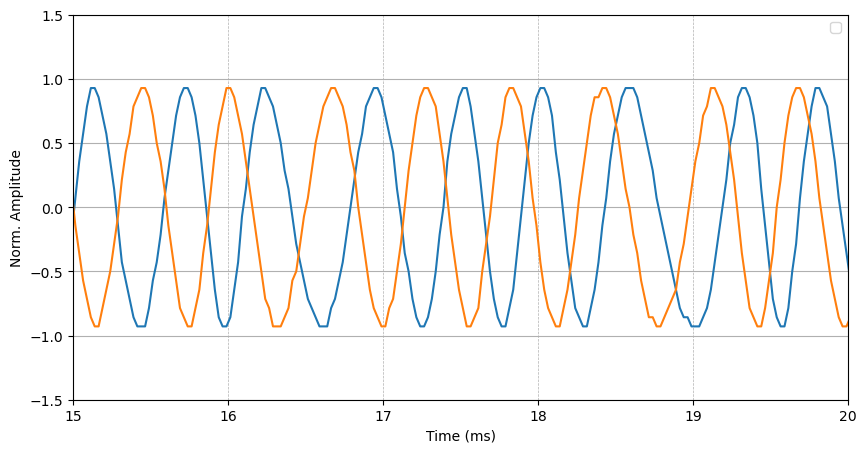

In [206]:
# Plotting
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.plot(scans[i].time[::5], scans[i].MI_signal_norm[::5])   # every 2nd point
plt.xlabel('Time (ms)')
plt.ylabel('Norm. Amplitude')
plt.xlim(15, 20)
plt.ylim(-1.5, 1.5)
plt.grid(True)
# Add grid lines every 5 seconds
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

In [293]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_sine_roi(time, signal, t_start_ms, t_end_ms, make_plot=True):
    """
    Fit A*sin(b*t + c) + d to signal within ROI [t_start_ms, t_end_ms].

    Returns
    -------
    A, b, c, d, f_hz
    """
    # --- ROI ---
    idx = (time >= t_start_ms) & (time <= t_end_ms)
    x = np.asarray(time[idx], float)
    y = np.asarray(signal[idx], float)

    # Shift time for numerical conditioning
    x0 = float(x.min())
    x = x - x0

    # --- Initial guess via FFT ---
    t_s = x * 1e-3
    dt = np.median(np.diff(t_s)) if len(t_s) > 1 else np.nan
    if np.isfinite(dt) and dt > 0:
        Y = np.fft.rfft(y - y.mean())
        freqs = np.fft.rfftfreq(len(y), d=dt)
        f0 = freqs[1 + np.argmax(np.abs(Y[1:]))] if len(freqs) > 1 else 1.0
    else:
        f0 = 1.0
    b0 = 2*np.pi*f0/1000.0  # rad/ms

    # --- Initials ---
    A0 = max(1e-6, 0.5*np.ptp(y))
    p0 = [A0, max(b0, 1e-6), 0.0, 0.0]

    # --- Bounds ---
    b_lo = max(1e-6, 0.25*b0)
    b_hi = max(1e-3, 4.0*b0)
    bounds = ([0.9, b_lo, 0.0, -0.1],
              [1.1, b_hi, 2*np.pi, 0.1])

    # --- Model and fit ---
    def sine_model(t, A, b, c, d): return A*np.sin(b*t + c) + d
    popt, _ = curve_fit(sine_model, x, y, p0=p0, bounds=bounds, maxfev=30000)

    A, b, c, d = popt
    f_hz = b * 1000.0 / (2*np.pi)
    y_fit = sine_model(x, A, b, c, d)
    res = y - y_fit

    # --- Plotting ---
    if make_plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True,
                                       gridspec_kw={'height_ratios': [3, 1]})

        ax1.plot(time, signal, alpha=0.25, label="Full signal")
        ax1.plot(x + x0, y, '.', ms=2, label="ROI data")
        ax1.plot(x + x0, y_fit, '-', lw=2, label="Sine fit")
        ax1.set_ylabel("Normalized Amplitude")
        ax1.legend(loc='upper right')

        ax2.plot(x + x0, res, '.', ms=2)
        ax2.axhline(0, lw=1)
        ax2.set_xlim(t_start_ms-1, t_end_ms+1)
        ax2.set_xlabel("Time [ms]")
        ax2.set_ylabel("Residual")

        plt.tight_layout()
        plt.legend(loc='upper right')
        plt.show()

    return A, b, c, d, f_hz


In [203]:
b_array = []
f_hz_array = []

for i in range(1,5):
    _, b, _, _, f_hz = fit_sine_roi(scans[i].time, scans[i].MI_signal_norm, 15, 19, make_plot=0)
    b_array.append(b)
    f_hz_array.append(f_hz)

nn = 0 
_, b, _, _, f_hz = fit_sine_roi(scans[nn].time, scans[nn].MI_signal_norm, 16.5, 20.5, make_plot=0)
b_array.append(b)
f_hz_array.append(f_hz)

nn = 5
_, b, _, _, f_hz = fit_sine_roi(scans[nn].time, scans[nn].MI_signal_norm, 16, 20, make_plot=0)
b_array.append(b)
f_hz_array.append(f_hz)

for i in range(6,9):
    _, b, _, _, f_hz = fit_sine_roi(scans[i].time, scans[i].MI_signal_norm, 15, 19, make_plot=0)
    b_array.append(b)
    f_hz_array.append(f_hz)

_, b, _, _, f_hz = fit_sine_roi(scans[9].time, scans[9].MI_signal_norm, 15.5, 19, make_plot=0)
b_array.append(b)
f_hz_array.append(f_hz)

In [204]:
print(b_array)
print(np.mean(b_array))
print(np.std(b_array))

[10.423499092882228, 10.317429079410603, 10.541321190092459, 10.481531130769035, 10.77783764269723, 10.229085283064938, 10.449952880238653, 10.37903396127018, 10.385992224188804, 10.441284562189807]
10.442696704680394
0.13876876630848078


## 1s scan 

In [353]:
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass

# --- define structure ---
@dataclass
class ScanData:
    time: np.ndarray
    MI_signal: np.ndarray
    MI_signal_norm: np.ndarray


# --- storage list ---
scans = []

# Example loop (adjust directory, filename, extension)
directory = './data/Waveform/'
filename = '20250910_waveform13_16_bit_with_offset-000'
extension = '.csv'

for i in range(2,7):
    # Build file path
    full_path = os.path.join(directory, f"{filename}{i}{extension}")
    data = pd.read_csv(full_path)

    # Convert columns
    time = pd.to_numeric(data['Time'], errors='coerce').to_numpy()
    MI_signal = pd.to_numeric(data['Channel B'], errors='coerce').to_numpy()

    # Drop NaNs from time (caused by headers like '(ms)')
    mask = ~np.isnan(time)
    time = time[mask]
    MI_signal = MI_signal[mask]

    # Post process
    offset = 0.5 * (np.max(MI_signal) + np.min(MI_signal))
    MI_signal_norm = (MI_signal - offset) / np.max(MI_signal - offset)

    # Store in structure
    scans.append(ScanData(time, MI_signal, MI_signal_norm))


# --- usage ---
print(scans[0].time[:5])          # first 5 points of time from scan 0
print(scans[2].MI_signal_norm)    # normalized signal of scan 2



[-0.00340166  0.00160634  0.00661434  0.01162234  0.01663034]
[0.91243687 0.93625212 0.93697377 ... 0.91772922 0.9037768  0.93553046]


C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\2480914029.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


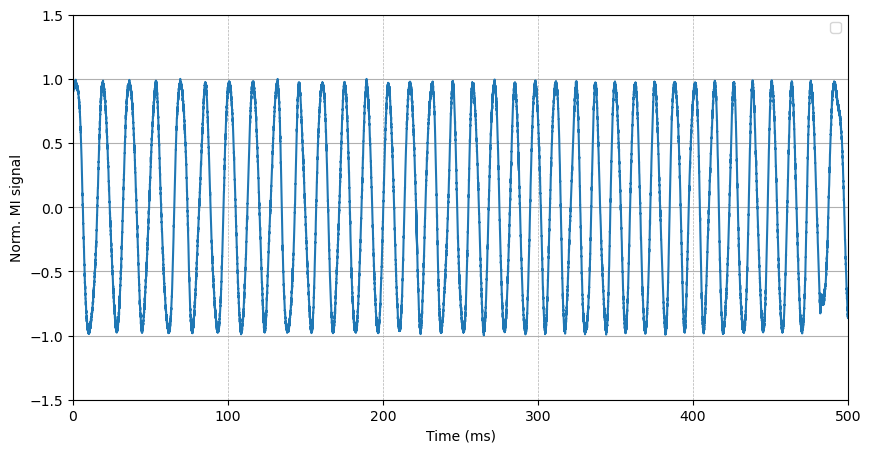

In [355]:
# Plotting
plt.figure(figsize=(10, 5))
for i in range(1):
    plt.plot(scans[i].time[::5], scans[i].MI_signal_norm[::5])   # every 2nd point
plt.xlabel('Time (ms)')
plt.ylabel('Norm. MI signal')
plt.xlim(0, 500)
plt.ylim(-1.5, 1.5)
plt.grid(True)
# Add grid lines every 5 seconds
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\4142738869.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


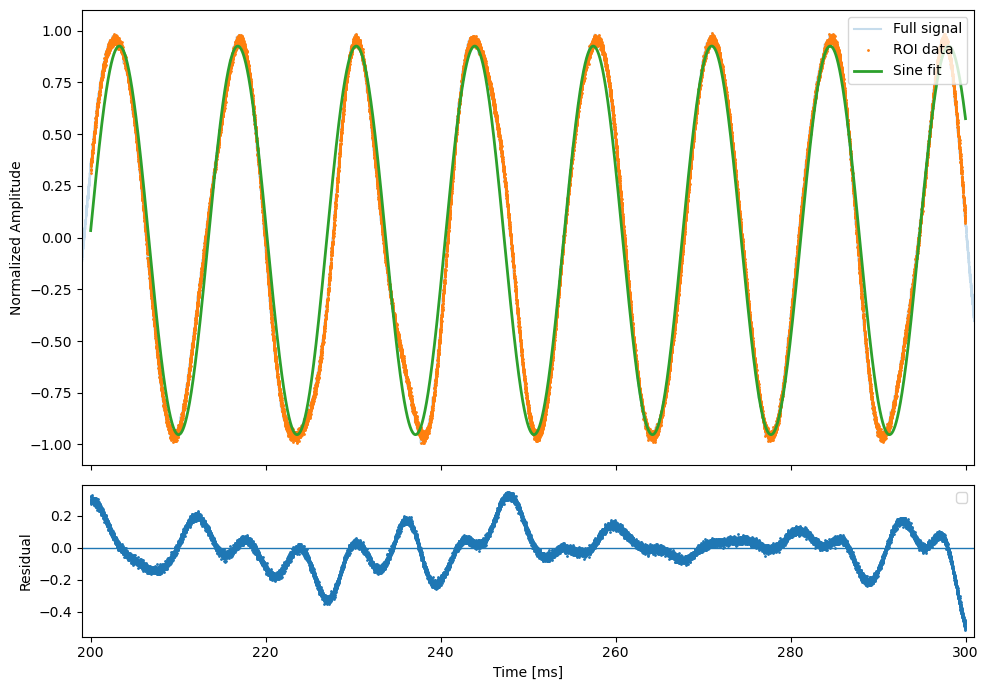

C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\2906393939.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


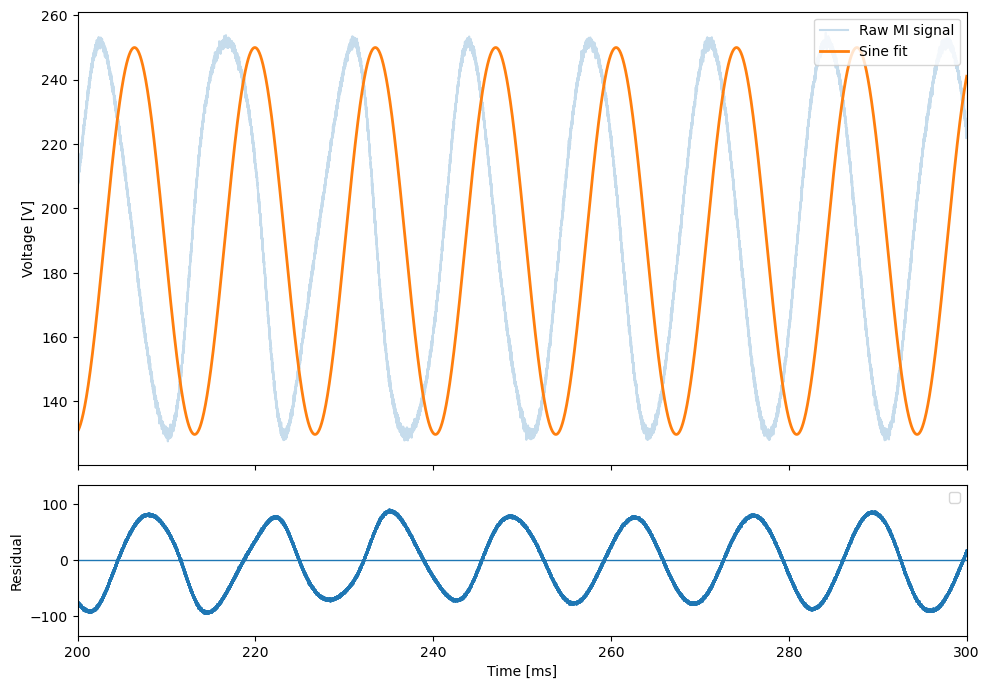

In [294]:
b_array = []
f_hz_array = []

t_start = 200
t_end = 300

for i in [1]:
    _, b, _, _, f_hz = fit_sine_roi(scans[i].time, scans[i].MI_signal_norm, t_start, t_end, make_plot=1)
    b_array.append(b)
    f_hz_array.append(f_hz)

Fit_result = A*np.sin(b*time + c) + d

Fit_to_real = Fit_result*np.max(MI_signal-offset) + offset

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(time, MI_signal, alpha=0.25, label="Raw MI signal")
ax1.plot(time, Fit_to_real, '-', lw=2, label="Sine fit")
ax1.set_ylabel("Voltage [V]")
ax1.legend(loc='upper right')

ax2.plot(time, Fit_to_real - MI_signal, '.', ms=2)
ax2.axhline(0, lw=1)
ax2.set_xlim(t_start, t_end)
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Residual")

plt.tight_layout()
plt.legend(loc='upper right')
plt.show()



# 500ms scan 

In [356]:
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass

# --- define structure ---
@dataclass
class ScanData:
    time: np.ndarray
    MI_signal: np.ndarray
    MI_signal_norm: np.ndarray


# --- storage list ---
scans = []
# Example loop (adjust directory, filename, extension)
directory = './data/Waveform/'
filename = '20250910_waveform14_16_bit_with_offset-000'
extension = '.csv'

for i in range(2,6):
    # Build file path
    full_path = os.path.join(directory, f"{filename}{i}{extension}")
    data = pd.read_csv(full_path)

    # Convert columns
    time = pd.to_numeric(data['Time'], errors='coerce').to_numpy()
    MI_signal = pd.to_numeric(data['Channel B'], errors='coerce').to_numpy()

    # Drop NaNs from time (caused by headers like '(ms)')
    mask = ~np.isnan(time)
    time = time[mask]
    MI_signal = MI_signal[mask]

    # Post process
    offset = 0.5 * (np.max(MI_signal) + np.min(MI_signal))
    MI_signal_norm = (MI_signal - offset) / np.max(MI_signal - offset)

    # Store in structure
    scans.append(ScanData(time, MI_signal, MI_signal_norm))


# --- usage ---
print(scans[0].time[:5])          # first 5 points of time from scan 0
print(scans[2].MI_signal_norm)    # normalized signal of scan 2



[-0.00405253  0.00095547  0.00596347  0.01097147  0.01597947]
[0.97468945 1.         0.96890441 ... 0.93105935 0.91514998 0.9308183 ]


C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\3813483568.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


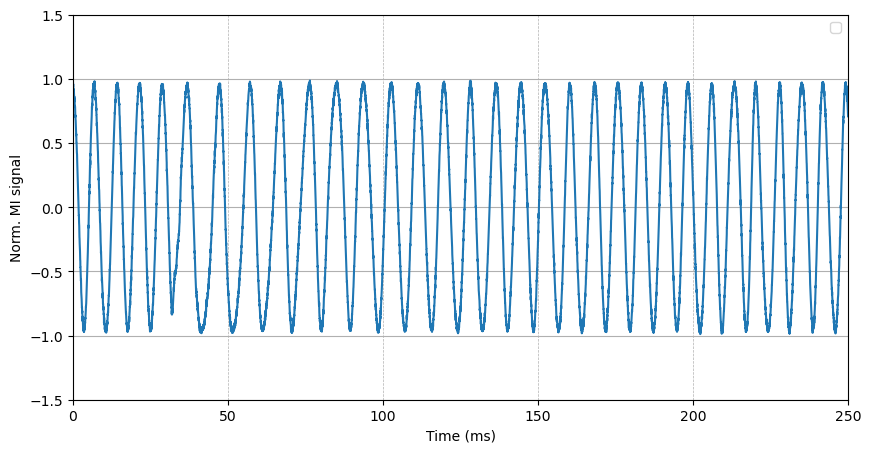

In [361]:
# Plotting
plt.figure(figsize=(10, 5))
for i in [3]:
    plt.plot(scans[i].time[::5], scans[i].MI_signal_norm[::5])   # every 2nd point
plt.xlabel('Time (ms)')
plt.ylabel('Norm. MI signal')
plt.xlim(0, 250)
plt.ylim(-1.5, 1.5)
plt.grid(True)
# Add grid lines every 5 seconds
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\4142738869.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


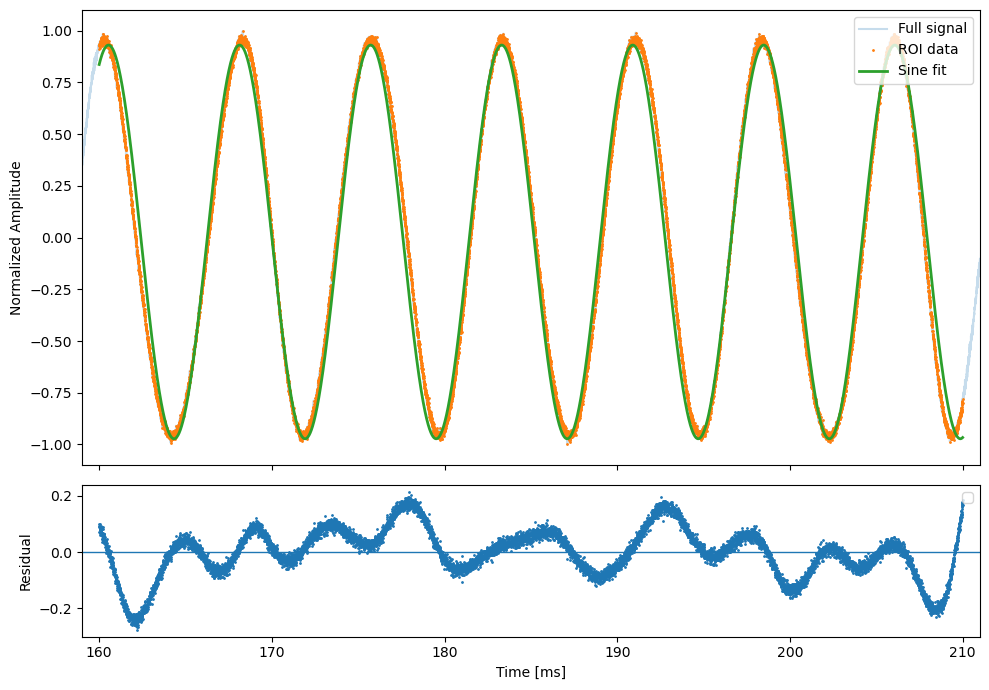

In [370]:
b_array = []
f_hz_array = []

t_start = 160
t_end = 210

for i in [3]:
    A, b, c, d, f_hz = fit_sine_roi(scans[i].time, scans[i].MI_signal_norm, t_start, t_end, make_plot=1)
    b_array.append(b)
    f_hz_array.append(f_hz)


# 250 ms

In [371]:
import os
import numpy as np
import pandas as pd
from dataclasses import dataclass

# --- define structure ---
@dataclass
class ScanData:
    time: np.ndarray
    MI_signal: np.ndarray
    MI_signal_norm: np.ndarray


# --- storage list ---
scans = []

# Example loop (adjust directory, filename, extension)
directory = './data/Waveform/'
filename = '20250910_waveform15_16_bit_with_offset-000'
extension = '.csv'

for i in [2,4,5]:
    # Build file path
    full_path = os.path.join(directory, f"{filename}{i}{extension}")
    data = pd.read_csv(full_path)

    # Convert columns
    time = pd.to_numeric(data['Time'], errors='coerce').to_numpy()
    MI_signal = pd.to_numeric(data['Channel B'], errors='coerce').to_numpy()

    # Drop NaNs from time (caused by headers like '(ms)')
    mask = ~np.isnan(time)
    time = time[mask]
    MI_signal = MI_signal[mask]

    # Post process
    offset = 0.5 * (np.max(MI_signal) + np.min(MI_signal))
    MI_signal_norm = (MI_signal - offset) / np.max(MI_signal - offset)

    # Store in structure
    scans.append(ScanData(time, MI_signal, MI_signal_norm))


# --- usage ---
print(scans[0].time[:5])          # first 5 points of time from scan 0
print(scans[2].MI_signal_norm)    # normalized signal of scan 2



[-0.00445423  0.00055377  0.00556177  0.01056977  0.01557777]
[ 0.96511917  1.          0.93913921 ... -0.09020937 -0.1029588
 -0.11137832]


C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\1900284327.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


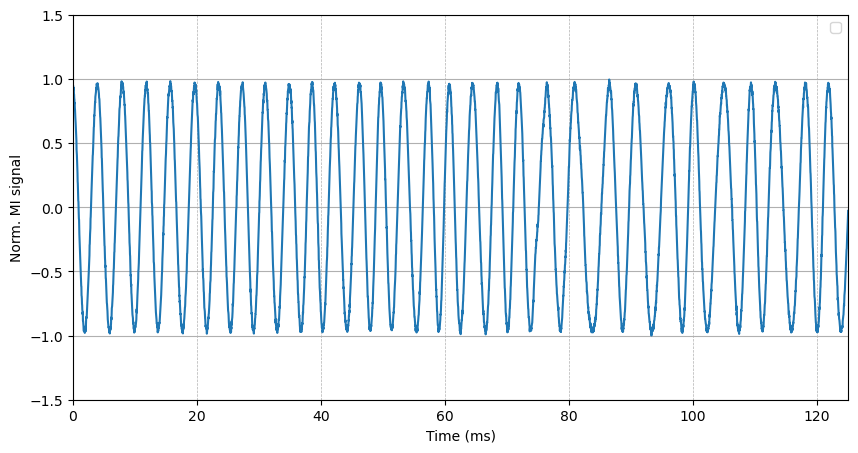

In [373]:
# Plotting
plt.figure(figsize=(10, 5))
for i in range(1):
    plt.plot(scans[i].time[::5], scans[i].MI_signal_norm[::5])   # every 2nd point
plt.xlabel('Time (ms)')
plt.ylabel('Norm. MI signal')
plt.xlim(0, 125)
plt.ylim(-1.5, 1.5)
plt.grid(True)
# Add grid lines every 5 seconds
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_8688\4142738869.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


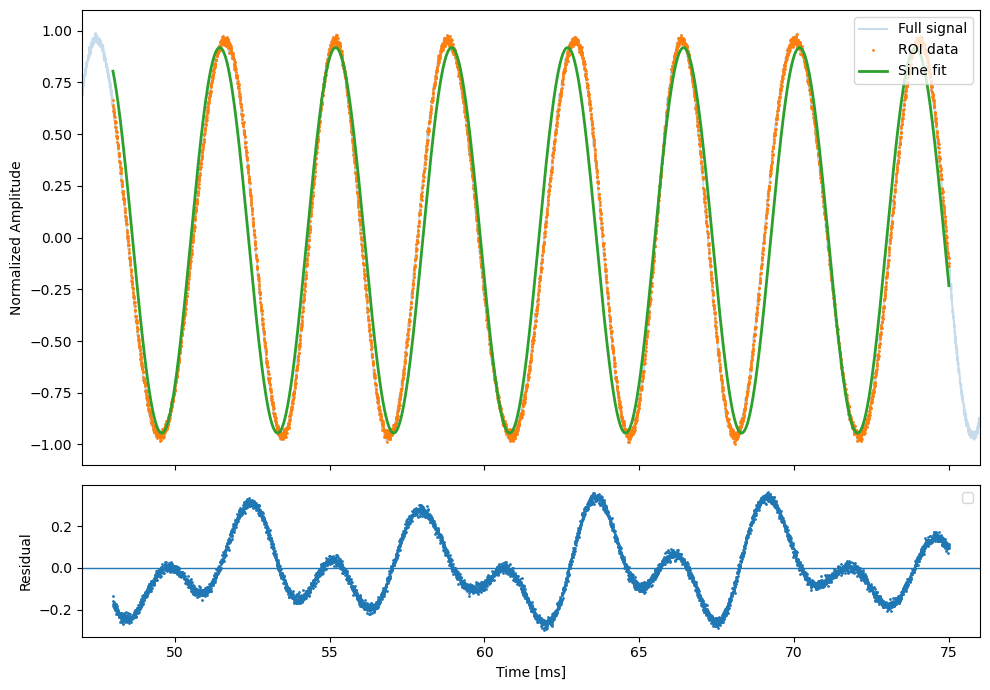

In [384]:
b_array = []
f_hz_array = []

t_start = 48
t_end = 75

for i in [1]:
    A, b, c, d, f_hz = fit_sine_roi(scans[i].time, scans[i].MI_signal_norm, t_start, t_end, make_plot=1)
    b_array.append(b)
    f_hz_array.append(f_hz)
